In [15]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from datetime import datetime
import os
import argparse
from utils.utils import  G, energy_calculator,Autoencoder
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
torch.set_default_dtype(torch.float32)
from scipy.integrate import solve_ivp


In [16]:
nx = 200
h = 1 / nx 
dt = .1*h**2

In [17]:
device = torch.device('cuda:2')
AE_folder = 'AE_dim_16_2024_05_18_09:40:37'
hidden_dim = int(AE_folder.split('_')[2])

AE = torch.load(f'./checkpoints/{AE_folder}/final.pt', map_location=device)
params = torch.load(f'./checkpoints/{AE_folder}/train/params.pt', map_location=device)
Z_mean = params['Z_mean']
Z_std = params['Z_std']
target_mean = params['target_mean']
target_std = params['target_std']

G_lz_path = './checkpoints/' + 'G_lz_dim_16_2024_05_18_22:33:08'
G_lx_path = './checkpoints/' + 'G_lx_dim_16_2024_05_18_22:45:28'

In [18]:
def RK4_func(t, y, g, hidden_dim=hidden_dim):
    with torch.no_grad():
        y = y.reshape(-1, hidden_dim) 
        y = (y - Z_mean) / Z_std
        f = g(y)
        f = f * target_std + target_mean
        f = f

        return f 

def rk4(f, t, y0, g):
    n = len(t)
    # y = [y0] * n  
    # print(len(y))
    y = torch.empty([n, y0.shape[0], y0.shape[1]], device=y0.device)
    y[0] = y0
    dt = t[1] - t[0]  # Assumes uniform spacing
    for i in tqdm(range(n - 1)):
        k1 = dt * f(t[i], y[i], g)
        k2 = dt * f(t[i] + dt / 2, y[i] + k1 / 2, g)
        k3 = dt * f(t[i] + dt / 2, y[i] + k2 / 2, g)
        k4 = dt * f(t[i] + dt, y[i] + k3, g)
        y[i + 1] = y[i] + (k1 + 2 * k2 + 2 * k3 + k4) / 6

    y = y.detach().cpu().numpy()
    return y


In [19]:
g_lx = torch.load(f'{G_lx_path}/G_final.pt', map_location=device)
g_lz = torch.load(f'{G_lz_path}/G_final.pt', map_location=device)

t_true = np.linspace(0, 40000*dt, 401)[:-1]
Z = torch.load(f'./checkpoints/{AE_folder}/train/data_test_interpolate_Z.pt', map_location=device)
print('hidden_dim:', hidden_dim)
Z = Z * Z_std + Z_mean
print('Z shape:', Z.shape) # [400, 50, 16]

hidden_dim: 16
Z shape: torch.Size([400, 50, 16])


In [20]:
t_eval = np.linspace(0, 40000*dt, 40001)
Z_0 = Z[0].to(device) # [50, 16]
Z_lz_pred = rk4(RK4_func, t_eval, Z_0, g_lz) # (40001, 50, 16)
Z_lz_pred = Z_lz_pred[::100][:-1]

Z_lx_pred = rk4(RK4_func, t_eval, Z_0, g_lx) # (40001, 50, 16)
Z_lx_pred = Z_lx_pred[::100][:-1]
Z = Z.detach().cpu().numpy()
print('Z_lz_pred shape:', Z_lz_pred.shape) # [400, 50, 16]
print('Z_lx_pred shape:', Z_lx_pred.shape) # [400, 50, 16]

100%|██████████| 40000/40000 [05:29<00:00, 121.30it/s]


Z_lz_pred shape: (400, 50, 16)
Z_lx_pred shape: (400, 50, 16)


In [21]:
norm = np.max(np.abs(Z[:,:,:1]))
Z[:,:,:1] = Z[:,:,:1] / norm
Z_lz_pred[:,:,:1] = Z_lz_pred[:,:,:1] / norm
Z_lx_pred[:,:,:1] = Z_lx_pred[:,:,:1] / norm

In [22]:
error_lz = np.sqrt(np.sum(np.square(Z_lz_pred - Z)[:,:,:1], -1))
error_lx = np.sqrt(np.sum(np.square(Z_lx_pred - Z)[:,:,:1], -1)) 

In [23]:
c_list = ['tab:blue', 'tab:orange','tab:olive','tab:red','tab:purple','k']

In [24]:
X = torch.load('raw_data/data_test_interpolate.pt')
X = X['u']

/tmp/ipykernel_2053031/1049105087.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  original_cmap = plt.cm.get_cmap('bwr')


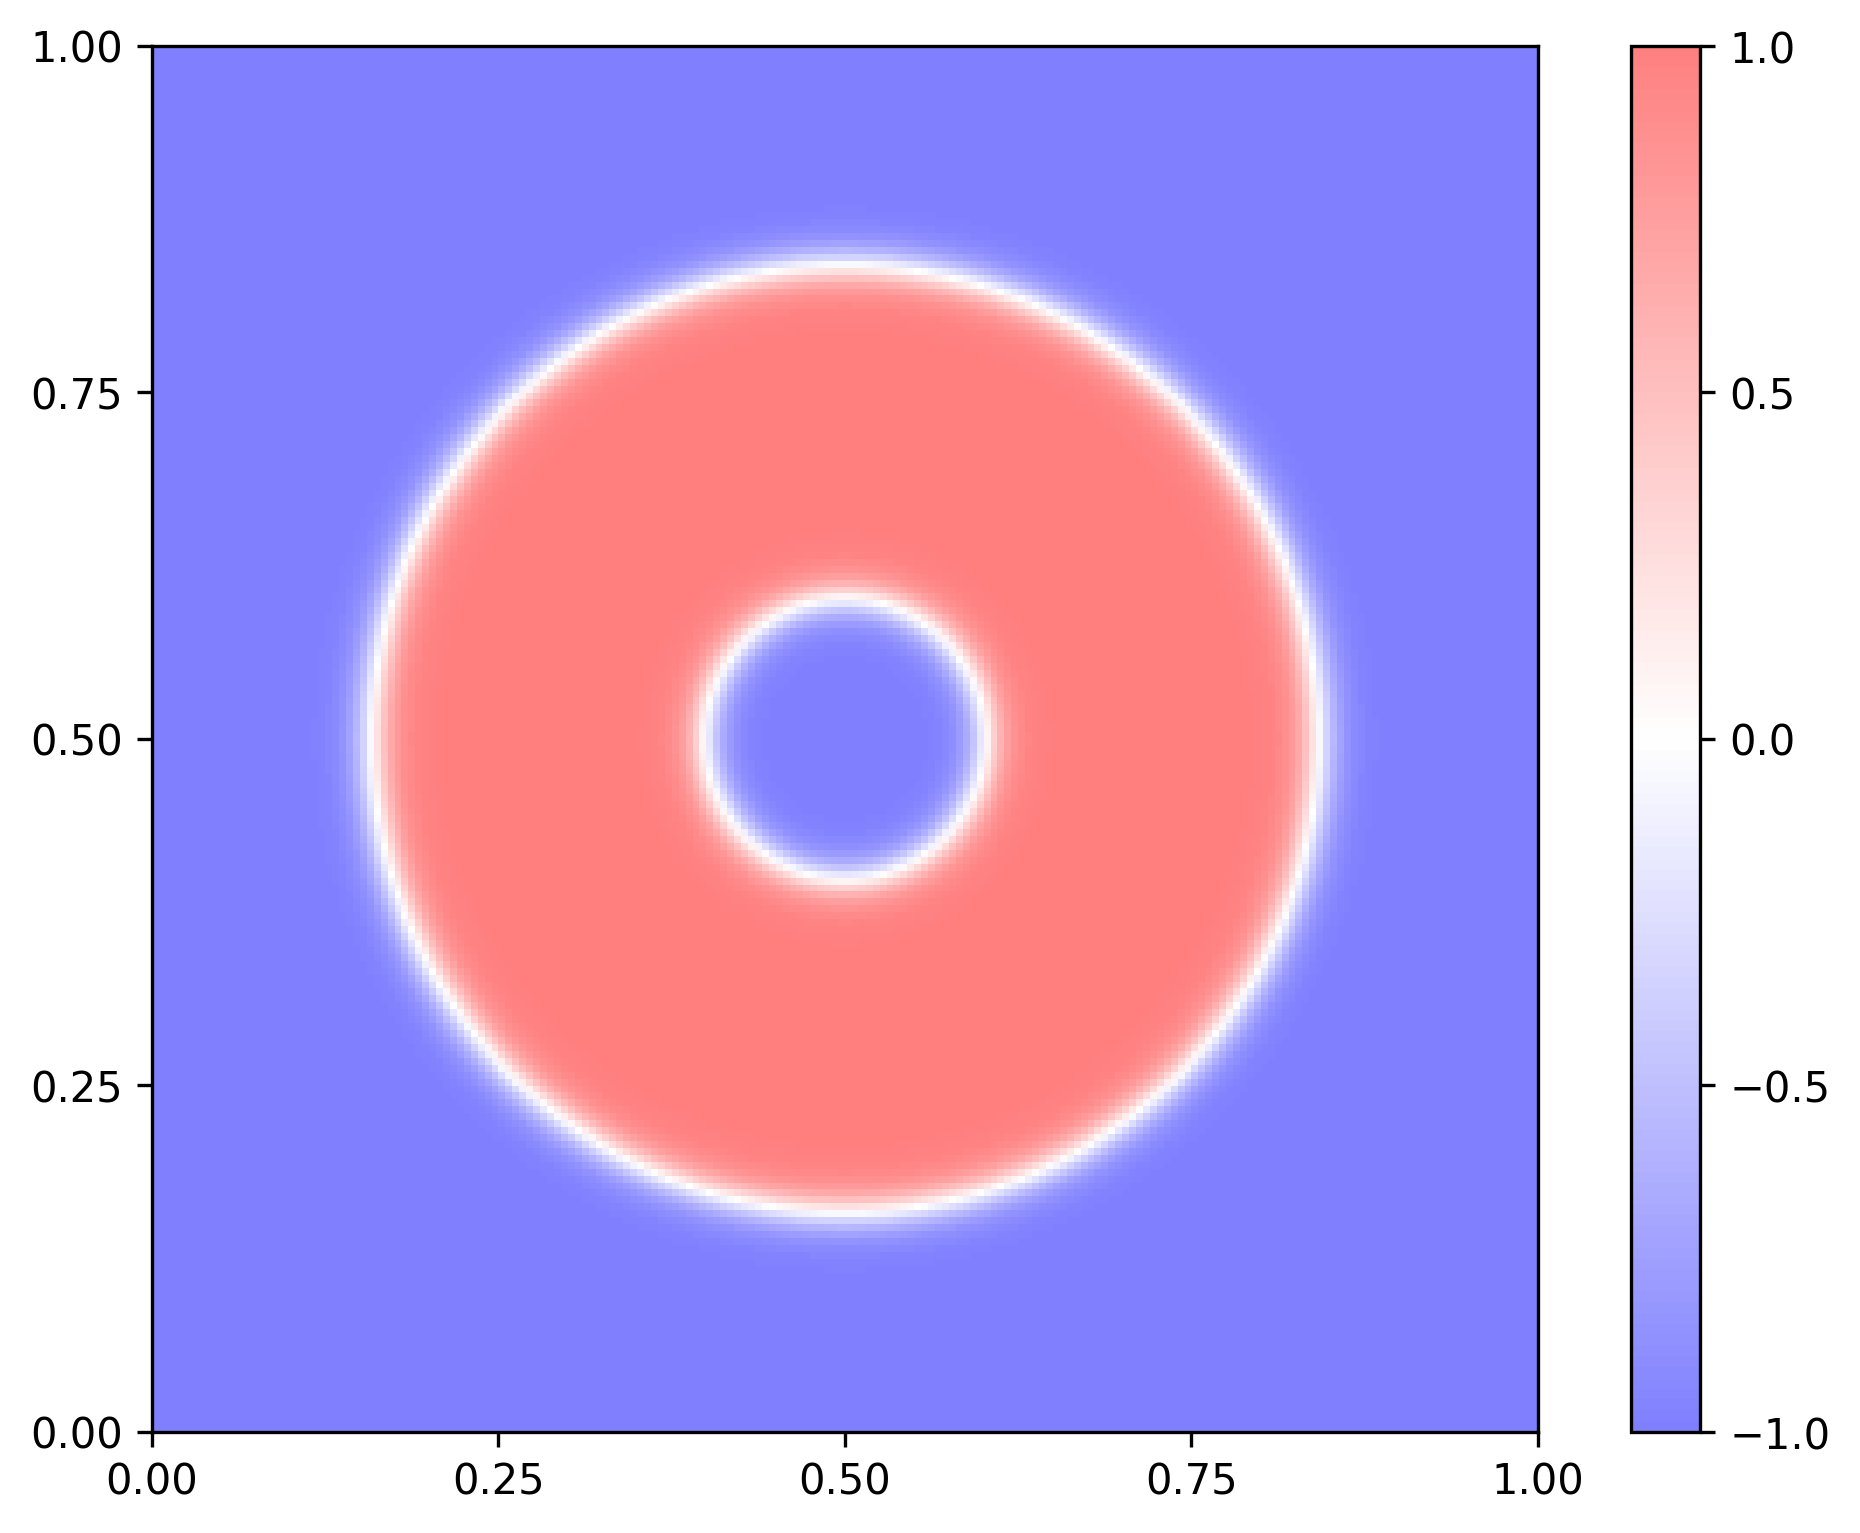

In [25]:
from matplotlib.colors import LinearSegmentedColormap
fig = plt.figure(figsize=(8,6),dpi=300)
original_cmap = plt.cm.get_cmap('bwr')
start = 0.25 
stop = 0.75
colors = original_cmap(np.linspace(start, stop, 256))
new_cmap = LinearSegmentedColormap.from_list('truncated_PiYG', colors)

plt.imshow(X[0,0], cmap=new_cmap, vmin=-1,vmax=1,origin='lower', extent= [0,1,0,1])
clb = plt.colorbar()
cc = 'white'
clb.set_ticks([-1,-0.5,0,0.5,1])
plt.xticks([0., 0.25, 0.5, 0.75, 1])
plt.yticks([0., 0.25, 0.5, 0.75, 1])
plt.savefig('imgs/patch.pdf')
plt.show()

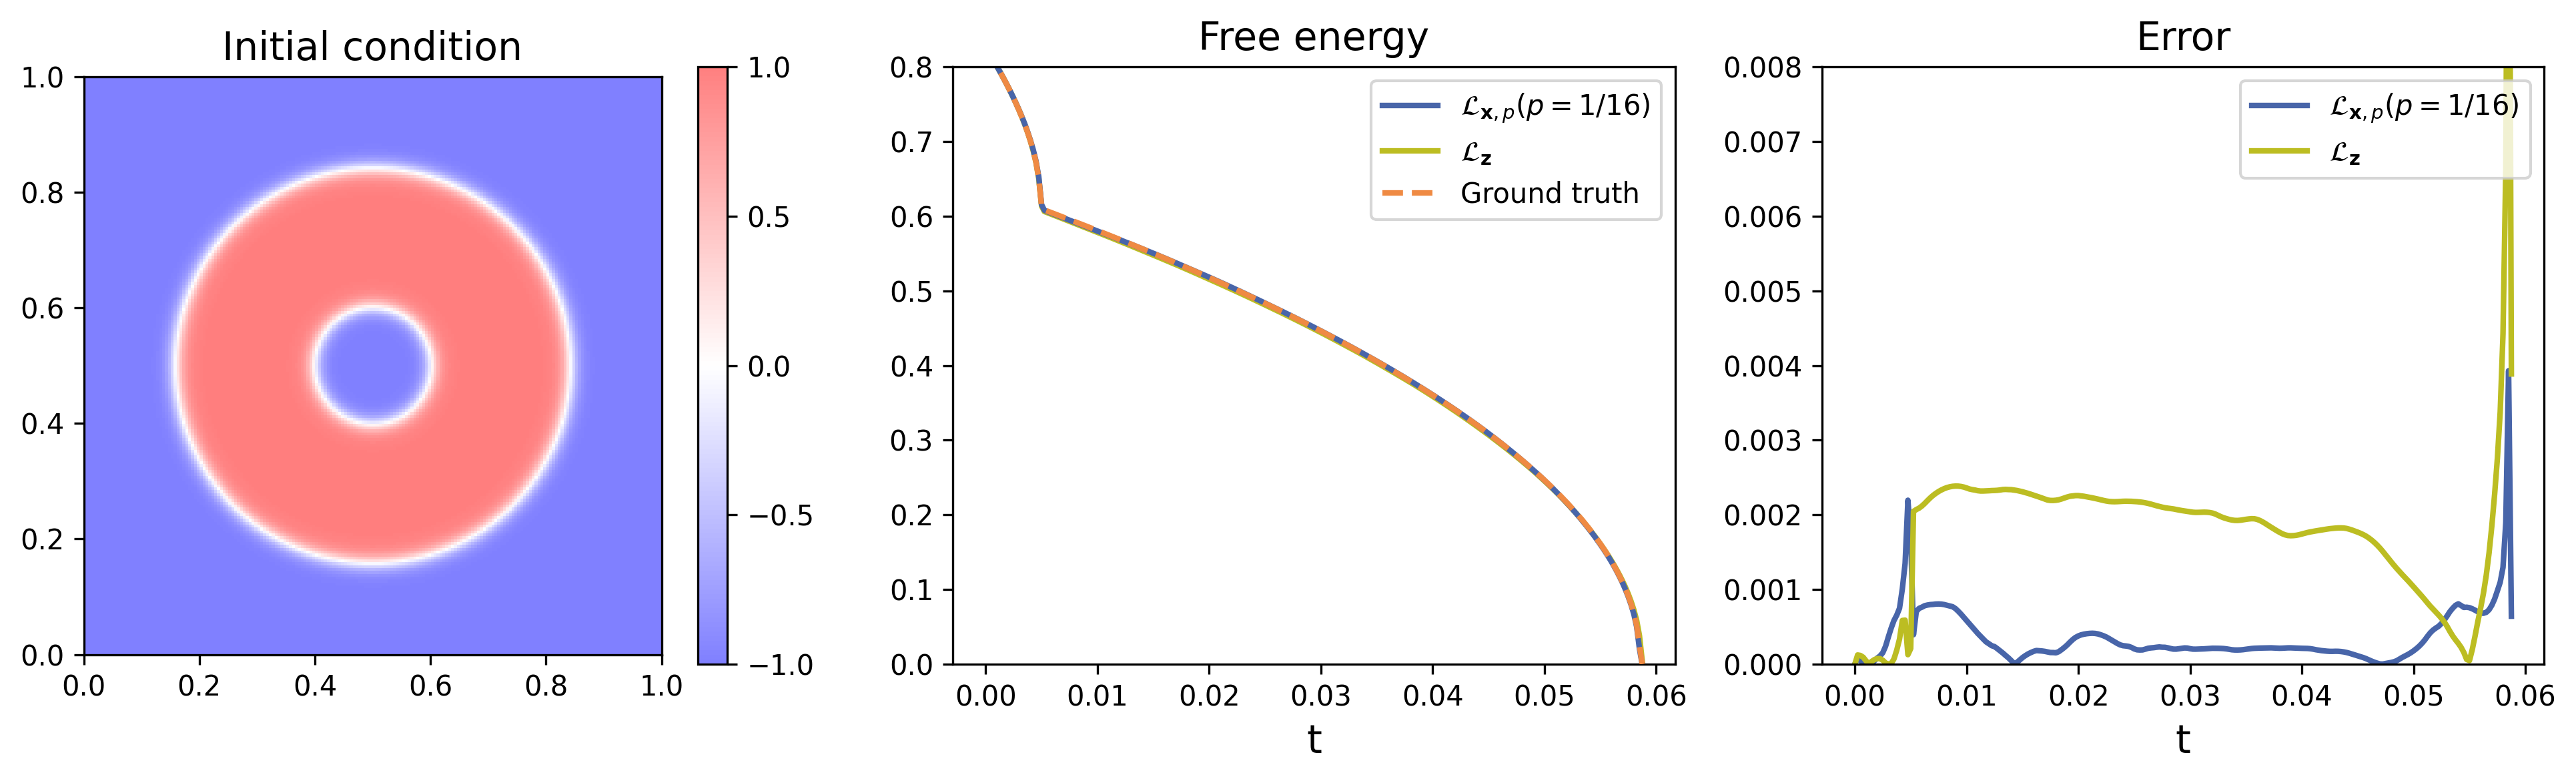

In [31]:
DPI = 300
Fontsize = 14
idx = 0 # 
fig = plt.figure(figsize=(13,4),dpi=DPI)
# Adjust the space between plots
fig.subplots_adjust(left=None, right=None, bottom=None, top=None, wspace=0.5, hspace=None)
axes = fig.add_subplot(1,3,1)
plt.imshow(X[0,0], cmap=new_cmap, vmin=-1,vmax=1,origin='lower', extent= [0,1,0,1])
clb = plt.colorbar()
clb.set_ticks([-1,-0.5,0,0.5,1])
axes.set_title('Initial condition', fontsize=Fontsize)

axes = fig.add_subplot(1,3,2)
t_idx = np.where(Z[:,idx,0] > 1e-4)[0]
t = t_true[t_idx]
axes.plot(t, Z_lx_pred[t_idx, idx, 0],'#4865A9',label='$\mathcal{L}_{\mathbf{x}, p}(p=1/16)$',linewidth=2,zorder=2)
axes.plot(t, Z_lz_pred[t_idx, idx, 0], 'tab:olive',label='$\mathcal{L}_\mathbf{z}$',linewidth=2,zorder=1)
axes.plot(t, Z[t_idx, idx, 0],c='#EF8A43',linestyle='--',label='Ground truth',linewidth=2,zorder=3)
axes.set_xlabel('t',fontsize=Fontsize)
axes.set_title('Free energy',fontsize=Fontsize)
axes.set_ylim(0, 0.8)
axes.legend(loc='upper right')

axes = fig.add_subplot(1,3,3)
axes.plot(t, error_lx[t_idx, idx],'#4865A9',label='$\mathcal{L}_{\mathbf{x}, p}(p=1/16)$',linewidth=2)
axes.plot(t, error_lz[t_idx, idx], 'tab:olive',label='$\mathcal{L}_\mathbf{z}$',linewidth=2)
axes.set_xlabel('t',fontsize=Fontsize)
axes.set_title('Error',fontsize=Fontsize)
axes.legend(loc='upper right')
axes.set_ylim(0, 0.008)

plt.tight_layout() 
# plt.savefig('imgs/Allen-Cahn_tra.pdf')
plt.show()


In [27]:
r1 = np.linspace(0.30, 0.40, 6)
r2 = np.linspace(0.10, 0.15, 6)
r1, r2 = np.meshgrid(r1, r2)
r1, r2 = r1.ravel(), r2.ravel()

In [28]:
r1[0]

0.3

In [29]:
r2[0]

0.1

In [30]:
X.shape

torch.Size([400, 50, 200, 200])